In [41]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from itertools import combinations

class OneVsOneClassifierCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model=LogisticRegression):
        self.base_model = base_model
        self.models = []
        self.class_pairs = []

    def fit(self, X, y):
        self.models = []
        self.class_pairs = []

        classes = np.unique(y)

        for (c1, c2) in combinations(classes, 2):
            idx = np.where((y == c1) | (y == c2))
            X_pair = X[idx]
            y_pair = y[idx]

            model = self.base_model()
            model.fit(X_pair, y_pair)

            self.models.append(model)
            self.class_pairs.append((c1, c2))

        return self

    def predict(self, X):
        votes = np.zeros((X.shape[0], len(self.class_pairs)))

        for i, model in enumerate(self.models):
            preds = model.predict(X)
            votes[:, i] = preds

        final_preds = []
        for row in votes:
            counts = np.bincount(row.astype(int))
            final_preds.append(np.argmax(counts))

        return np.array(final_preds)


In [42]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [61]:
# Cargar datos
iris = load_iris()
X = iris.data
y = iris.target
clases = [0, 1,2] 
# Filtrar dataset según clases elegidas
idx = np.isin(y, clases)
X_sel = X[idx]
y_sel = y[idx]

# Entrenar OVO
ovo = OneVsOneClassifierCustom()
ovo.fit(X_sel, y_sel)
y_pred = ovo.predict(X_sel)

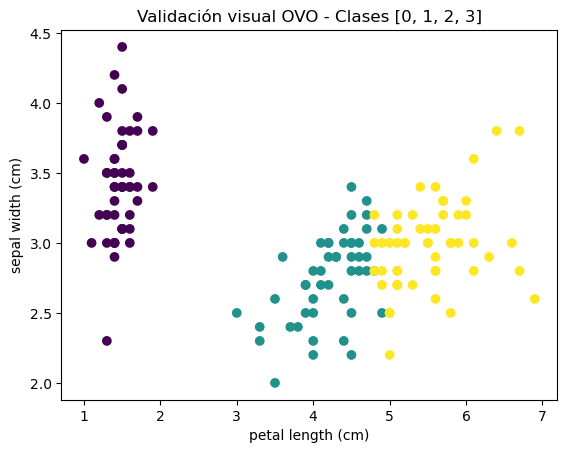

In [60]:

# Seleccionas qué columnas originales quieres para el plano 2D
feature_x = 2
feature_y = 1

plt.scatter(X_sel[:, feature_x], X_sel[:, feature_y], c=y_pred)
plt.xlabel(iris.feature_names[feature_x])
plt.ylabel(iris.feature_names[feature_y])
plt.title(f"Validación visual OVO - Clases {clases}")
plt.show()
